In [ ]:
%matplotlib inline

In [ ]:
!pip3 install torch

In [ ]:
!pip3 install tensorflow

     |████████████████████████████████| 462 kB 34.6 MB/s 


In [ ]:
!pip3 install torchvision

In [ ]:
!pip3 install google.colab

In [ ]:
from __future__ import print_function, division

import torch
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import torch.utils.data as data
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import os.path
import copy
from torch.nn import functional as F

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/faces'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(device)

cuda:0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


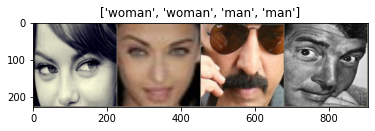

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6210 Acc: 0.7600
val Loss: 0.2730 Acc: 0.8941

Epoch 1/5
----------
train Loss: 0.5639 Acc: 0.7731
val Loss: 0.1583 Acc: 0.9353

Epoch 2/5
----------
train Loss: 0.5307 Acc: 0.8031
val Loss: 0.1929 Acc: 0.9235

Epoch 3/5
----------
train Loss: 0.4370 Acc: 0.8319
val Loss: 0.1757 Acc: 0.9294

Epoch 4/5
----------
train Loss: 0.3975 Acc: 0.8488
val Loss: 0.1836 Acc: 0.9059

Epoch 5/5
----------
train Loss: 0.3846 Acc: 0.8481
val Loss: 0.2149 Acc: 0.9029

Training complete in 4m 49s
Best val Acc: 0.935294


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


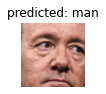

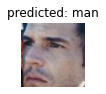

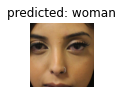

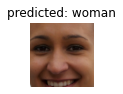

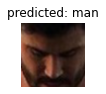

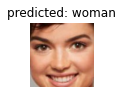

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6350 Acc: 0.6950
val Loss: 1.4918 Acc: 0.5353

Epoch 1/5
----------
train Loss: 0.6478 Acc: 0.7231
val Loss: 0.3026 Acc: 0.8824

Epoch 2/5
----------
train Loss: 0.5551 Acc: 0.7662
val Loss: 0.4326 Acc: 0.8647

Epoch 3/5
----------
train Loss: 0.6454 Acc: 0.7250
val Loss: 0.3477 Acc: 0.8647

Epoch 4/5
----------
train Loss: 0.5488 Acc: 0.7594
val Loss: 0.3220 Acc: 0.8500

Epoch 5/5
----------
train Loss: 0.5908 Acc: 0.7475
val Loss: 0.3135 Acc: 0.8765

Training complete in 1m 6s
Best val Acc: 0.882353


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


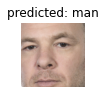

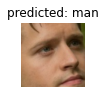

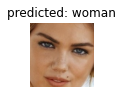

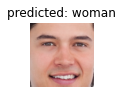

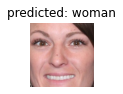

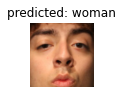

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
#trying with another model
model_ft = models.vgg16(pretrained=True)
print(model_ft)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

need to change last 6 layer of classificator 

In [ ]:
#обучаю целиком, заменив последний слой
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features

model_ft.classifier[6] = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4938 Acc: 0.7519
val Loss: 0.2538 Acc: 0.8824

Epoch 1/5
----------
train Loss: 0.3042 Acc: 0.8794
val Loss: 0.1701 Acc: 0.9147

Epoch 2/5
----------
train Loss: 0.2903 Acc: 0.8688
val Loss: 0.2069 Acc: 0.9118

Epoch 3/5
----------
train Loss: 0.2189 Acc: 0.9062
val Loss: 0.1295 Acc: 0.9529

Epoch 4/5
----------
train Loss: 0.2238 Acc: 0.9100
val Loss: 0.1230 Acc: 0.9471

Epoch 5/5
----------
train Loss: 0.1876 Acc: 0.9213
val Loss: 0.2119 Acc: 0.9176

Training complete in 4m 27s
Best val Acc: 0.952941


In [ ]:
#обучаю только последний слой
model_conv = torchvision.models.vgg16(pretrained=True)

num_ftrs = model_ft.classifier[6].in_features

for param in model_conv.parameters():
    param.requires_grad = False
    
model_conv.classifier[6] = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.classifier[6].parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6032 Acc: 0.7881
val Loss: 0.4395 Acc: 0.8265

Epoch 1/5
----------
train Loss: 0.6206 Acc: 0.8169
val Loss: 0.5525 Acc: 0.8235

Epoch 2/5
----------
train Loss: 0.7112 Acc: 0.8113
val Loss: 0.4082 Acc: 0.8765

Epoch 3/5
----------
train Loss: 0.7404 Acc: 0.8119
val Loss: 0.3630 Acc: 0.8794

Epoch 4/5
----------
train Loss: 0.7665 Acc: 0.8113
val Loss: 0.4489 Acc: 0.8647

Epoch 5/5
----------
train Loss: 0.7402 Acc: 0.8237
val Loss: 0.5084 Acc: 0.8676

Training complete in 1m 41s
Best val Acc: 0.879412


In [ ]:
def has_file_allowed_extension(filename):
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in IMG_EXTENSIONS)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if  os.path.isdir (os.path.join (dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in  range (len (classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in  sorted (os.walk (d)):
            for fname in sorted(fnames):
                if has_file_allowed_extension(fname):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append (item)
    return  images

IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class MyDataset(data.Dataset):
  def __init__(self, root, transform = None):
        classes, class_to_idx = find_classes(root)
        samples = make_dataset(root, class_to_idx)
        if len(samples) == 0:
            raise(RuntimeError("Found 0 files in subfolders of: " + root + "\n"))
        self.root = root
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.transform = transform
        self.imgs = self.samples
        self.loader = pil_loader
  
  def __len__(self):
    return len(self.samples)

  def __getitem__(self, index):
    path, target = self.samples[index]
    sample = self.loader(path)
    if self.transform is not None:
        sample = self.transform(sample)
    return sample, target

In [ ]:
my_datasets = {x: MyDataset(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(my_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(my_datasets[x]) for x in ['train', 'val']}
class_names = my_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


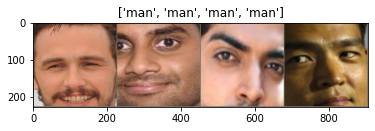

In [ ]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
#обучу сеть на своем MyDataset
#обучаю целиком:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2135 Acc: 0.9144
val Loss: 0.1080 Acc: 0.9618

Epoch 1/5
----------
train Loss: 0.1954 Acc: 0.9200
val Loss: 0.0862 Acc: 0.9794

Epoch 2/5
----------
train Loss: 0.1840 Acc: 0.9263
val Loss: 0.0932 Acc: 0.9676

Epoch 3/5
----------
train Loss: 0.1873 Acc: 0.9244
val Loss: 0.1058 Acc: 0.9618

Epoch 4/5
----------
train Loss: 0.1777 Acc: 0.9313
val Loss: 0.0848 Acc: 0.9765

Epoch 5/5
----------
train Loss: 0.1781 Acc: 0.9313
val Loss: 0.0988 Acc: 0.9676

Training complete in 1m 27s
Best val Acc: 0.979412


In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6217 Acc: 0.7000
val Loss: 0.3251 Acc: 0.8676

Epoch 1/5
----------
train Loss: 0.5786 Acc: 0.7381
val Loss: 0.8713 Acc: 0.7088

Epoch 2/5
----------
train Loss: 0.6089 Acc: 0.7438
val Loss: 0.3583 Acc: 0.8706

Epoch 3/5
----------
train Loss: 0.6447 Acc: 0.7313
val Loss: 0.3088 Acc: 0.8735

Epoch 4/5
----------
train Loss: 0.5898 Acc: 0.7469
val Loss: 0.3285 Acc: 0.8912

Epoch 5/5
----------
train Loss: 0.5924 Acc: 0.7456
val Loss: 0.3947 Acc: 0.8676

Training complete in 1m 7s
Best val Acc: 0.891176


In [ ]:
#своя сеть из слоёв, обучаю на датасете своего класса MyDataset
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
model = SimpleCnn(2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6926 Acc: 0.5106
val Loss: 0.6923 Acc: 0.5000

Epoch 1/5
----------
train Loss: 0.6598 Acc: 0.6131
val Loss: 0.6242 Acc: 0.6294

Epoch 2/5
----------
train Loss: 0.6391 Acc: 0.6488
val Loss: 0.6065 Acc: 0.6853

Epoch 3/5
----------
train Loss: 0.6170 Acc: 0.6650
val Loss: 0.6418 Acc: 0.6824

Epoch 4/5
----------
train Loss: 0.6111 Acc: 0.6763
val Loss: 0.5694 Acc: 0.6941

Epoch 5/5
----------
train Loss: 0.6103 Acc: 0.6569
val Loss: 0.5974 Acc: 0.7029

Training complete in 1m 9s
Best val Acc: 0.702941


In [ ]:
#результаты дообучения:

#resnet18 целиком: 93%
#resnet18 последний слой: 88%

#vgg16 целиком: 95%
#vgg16 последний слой: 87%

#resnet18 целиком на faces: 97%
#resnet18 последний слой на faces: 89%

#моя сверточная сеть на faces: 70%